# AoS Analysis

This analysis uses AoS data (collected from wahapedia.ru/aos3/factions/hedonites-of-slaanesh/warscrolls.html) 
and OLS techniques to decompose the points cost of individual AOS units. Specifically, the residuals from a 
hierarchical regression (with moderation terms) will be examined. These residuals represent the differences 
between the actual points costs and those predicted by the model. Therefore units with large negative residuals 
would represent AoS units which are currently 'undercosted' based on the features included in the model. When 
selecting units it would beneficial to select more units that are 'undercosted' and avoid those 'overcosted'.

## Research Questions:

1) Which AoS units are currently over-valued based on their warscroll values;
2) which AoS units are currently under-valued based on their warscroll values; and,
3) is there currently a "summoning tax" for HoS specific units?

In [1]:
#####################################################################################
# Wahapedia Analysis
#####################################################################################

# Import packages.

# cwd = os.getcwd()
# print(cwd)

# removes scientific notation.
#np.set_printoptions(suppress=True)


import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup


In [2]:
# Import wahapedia csv.

# In the other notebook I attempted to use bs4 to scrape the warscroll details, however
# I couldn't extract the data in a useable form. Will have another look later as this 
# will greatly improve the ability to point this analysis at different factions (not just HoS).

df = pd.read_csv("2023-10-17 Project HOS input.csv")

# Developing a codebook.

codebook = pd.DataFrame(df.dtypes)[1:len(df.dtypes)]
codebook["Variable"] = 0

codebook["Variable"] = [
    "units name (units can have multiple models)",
    "name of each weapons profile (models/units can have multiple)",
    "range of each weapon profiles attacks",
    "attack: number of dice rolled per weapon",
    "to hit roll: attack rolls above this values are hits",
    "to wound roll: hit rolls above this value force oppenent save rolls",
    "rend value: minus this value from oppenents save rolls",
    "damage value: oppenents failed save rolls cause this many wounds to oppenents models",
    "move: models movement (in inches)",
    "wounds: each model (in unit) can take this many wounds until it is removed",
    "bravery: each unit can remove this many models before (guaranteed) attrition",
    "save roll: roll below this value prevent oppenents successful to-wound rolls ",
    "ward rolls: roll below to prevent oppenents successful to-wound rolls (after failed save rolls)",
    "descriptive string: many units have idiosyncratic abilities common-easierly imputed ones are recorded here",
    "unit size: how many models are in this unit",
    "points per warscroll: in-game points cost for each unit (of models)",
    "spells: number of spells this unit can cast per turn",
    "slaanesh dummy variable"]

#pd.options.display.max_colwidth = 90

display(codebook["Variable"])


unit_name                     units name (units can have multiple models)
weapon_name             name of each weapons profile (models/units can...
Range                               range of each weapon profiles attacks
A                                attack: number of dice rolled per weapon
H                       to hit roll: attack rolls above this values ar...
W                       to wound roll: hit rolls above this value forc...
R                       rend value: minus this value from oppenents sa...
D                       damage value: oppenents failed save rolls caus...
Move                                    move: models movement (in inches)
Wounds                  wounds: each model (in unit) can take this man...
Bravery                 bravery: each unit can remove this many models...
Save                    save roll: roll below this value prevent oppen...
Ward                    ward rolls: roll below to prevent oppenents su...
Ability                 descriptive st

In [3]:
#####################################################################################
# Data Cleaning:

df = df.drop("id", axis = 1)

# Need to replace the string/chars with numeric.
def string_replacer(x):
    x = x.replace("2D6", "7")
    x = x.replace("D3", "2")
    x = x.replace("3D6", "10.5")
    x = x.replace("D6", "3.5")
    x = x.replace("sigvald.charge", "7")
    x = x.astype(float)
    return(x)

# Need to the function to impute/fix string data points.
# df.dtypes
df["A"] = string_replacer(df["A"])
df["W"] = string_replacer(df["W"])
df["D"] = string_replacer(df["D"])
df["Move"] = string_replacer(df["Move"])

# Going to invert some of the features so that their coefs
# represent unit improvements (i.e., to-hit rolls on a 2+ are
# easier than to-hit rolls on a 4+ etc). 
df["Save"] = 7 - df["Save"]
df["Ward"] = 7 - df["Ward"]
df["H"] = 7 - df["H"]
df["W"] = 7 - df["W"]



#####################################################################################

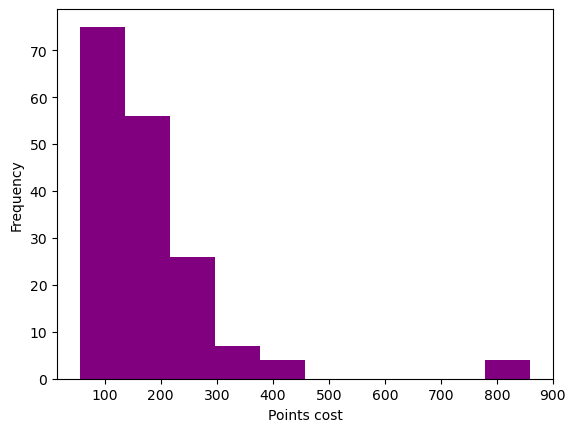

In [4]:
#####################################################################################
# EDA

# Histogram of points costs.
plt.hist(df["Points_per_warscroll"], color="purple")
plt.xlabel("Points cost")
plt.ylabel("Frequency")
plt.show()

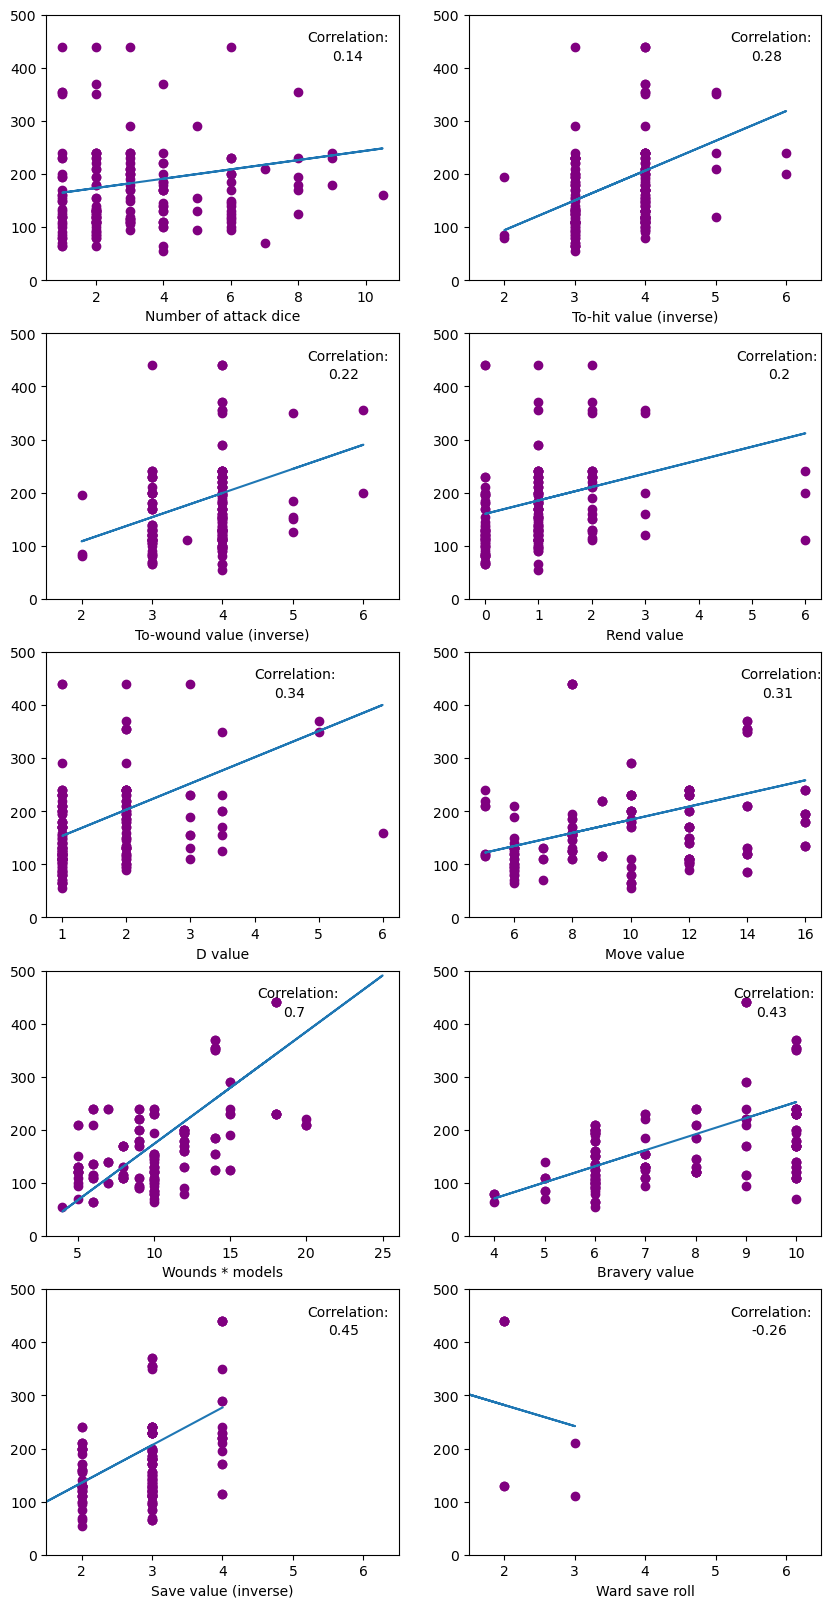

In [5]:
# Warscroll Scatterplots.

# setting up multi-figure object.
figure, axis = plt.subplots(5,2, figsize = (10, 20))

##########################################
# Chart 1.
# Attack Profile.
b1, b0 = np.polyfit(df["A"], df["Points_per_warscroll"], 1)
axis[0,0].plot(df["A"], b1*df["A"]+b0)

axis[0,0].scatter(df["A"], df["Points_per_warscroll"], color="purple")
axis[0,0].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[0,0].set_xlabel("Number of attack dice")
#plt.xlabel("Number of attack dice")
axis[0,0].text(8.25, 450, "Correlation:")
axis[0,0].text(9, 415, round(np.corrcoef(df["A"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")

##########################################
# Chart 2.
# to-Hit Profile.
b1, b0 = np.polyfit(df["H"], df["Points_per_warscroll"], 1)
axis[0,1].plot(df["H"], b1*df["H"]+b0)

axis[0,1].scatter(df["H"], df["Points_per_warscroll"], color="purple")
axis[0,1].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[0,1].set_xlim((1.5,6.5))
axis[0,1].set_xlabel("To-hit value (inverse)")
#plt.xlabel("To-hit value (must roll above i.e., lower values better)")
axis[0,1].text(5.2, 450, "Correlation:")
axis[0,1].text(5.5, 415, round(np.corrcoef(df["H"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")

##########################################
# Chart 3.
# to-Wound Profile.
b1, b0 = np.polyfit(df["W"], df["Points_per_warscroll"], 1)
axis[1,0].plot(df["W"], b1*df["W"]+b0)

axis[1,0].scatter(df["W"], df["Points_per_warscroll"], color="purple")
axis[1,0].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[1,0].set_xlim((1.5,6.5))
axis[1,0].set_xlabel("To-wound value (inverse)")
#axis[1,0].plt.xlabel("To-wound value (must roll above i.e., lower values better)")
axis[1,0].text(5.2, 450, "Correlation:")
axis[1,0].text(5.5, 415, round(np.corrcoef(df["W"], df["Points_per_warscroll"])[1][0],2))
#axis[1,0].plt.ylabel("Points cost")

##########################################
# Chart 4. 
# R Profile.
b1, b0 = np.polyfit(df["R"], df["Points_per_warscroll"], 1)
axis[1,1].plot(df["R"], b1*df["R"]+b0)

axis[1,1].scatter(df["R"], df["Points_per_warscroll"], color="purple")
axis[1,1].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[1,1].set_xlabel("Rend value")
#plt.xlabel("Rend value (minus this value from oppenent save rolls)")
axis[1,1].text(4.7, 450, "Correlation:")
axis[1,1].text(5.3, 415, round(np.corrcoef(df["R"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")

##########################################
# Chart 5. 
# D Profile.
b1, b0 = np.polyfit(df["D"], df["Points_per_warscroll"], 1)
axis[2,0].plot(df["D"], b1*df["D"]+b0)

axis[2,0].scatter(df["D"], df["Points_per_warscroll"], color="purple")
axis[2,0].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[2,0].set_xlabel("D value")
#plt.xlabel("Damage per attack dice")
axis[2,0].text(4, 450, "Correlation:")
axis[2,0].text(4.3, 415, round(np.corrcoef(df["D"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")

##########################################
# Chart 6. 
# Move Profile.
b1, b0 = np.polyfit(df["Move"], df["Points_per_warscroll"], 1)
axis[2,1].plot(df["Move"], b1*df["Move"]+b0)

axis[2,1].scatter(df["Move"], df["Points_per_warscroll"], color="purple")
axis[2,1].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[2,1].set_xlabel("Move value")
#axis[2,1].xlabel("Movement range")
axis[2,1].text(13.75, 450, "Correlation:")
axis[2,1].text(14.5, 415, round(np.corrcoef(df["Move"], df["Points_per_warscroll"])[1][0],2))
#axis[2,1].ylabel("Points cost")

##########################################
# Chart 7.
# Wounds Profile.
df["Wounds_X_model"] = 0

# so the points cost refers to the unit, whilst wounds relates to each model 
# (units are full of models [e.g., a unit of 10 models]). So need to create a
# Wounds * Models feature.
df["Wounds_X_model"] = df["Wounds"] * df["unit_size"]

b1, b0 = np.polyfit(df["Wounds_X_model"], df["Points_per_warscroll"], 1)
axis[3,0].plot(df["Wounds_X_model"], b1*df["Wounds_X_model"]+b0)

axis[3,0].scatter(df["Wounds_X_model"], df["Points_per_warscroll"], color="purple")
axis[3,0].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
#plt.xlabel("Wounds count (per unit)")
axis[3,0].set_xlabel("Wounds * models")
axis[3,0].text(16.75, 450, "Correlation:")
axis[3,0].text(18.5, 415, round(np.corrcoef(df["Wounds_X_model"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")
# plt.legend(loc="upper left")

##########################################
# Chart 8
# Bravery Profile.
b1, b0 = np.polyfit(df["Bravery"], df["Points_per_warscroll"], 1)
axis[3,1].plot(df["Bravery"], b1*df["Bravery"]+b0)

axis[3,1].scatter(df["Bravery"], df["Points_per_warscroll"], color="purple")
axis[3,1].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[3,1].set_xlim((3.5,10.5))
#plt.xlabel("Bravery value")
axis[3,1].set_xlabel("Bravery value")
axis[3,1].text(8.75, 450, "Correlation:")
axis[3,1].text(9.2, 415, round(np.corrcoef(df["Bravery"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")
# plt.legend(loc="upper left")

##########################################
# Chart 9
# Save Profile.
b1, b0 = np.polyfit(df["Save"], df["Points_per_warscroll"], 1)
axis[4,0].plot(df["Save"], b1*df["Save"]+b0)

axis[4,0].scatter(df["Save"], df["Points_per_warscroll"], color="purple")
axis[4,0].set_xlabel("Save value (inverse)")
axis[4,0].set_ylim((0,500)) # need to use these "set" commands for multi-charts.
axis[4,0].set_xlim((1.5,6.5))
#plt.xlabel("Save roll")
axis[4,0].text(5.2, 450, "Correlation:")
axis[4,0].text(5.5, 415, round(np.corrcoef(df["Save"], df["Points_per_warscroll"])[1][0],2))
#plt.ylabel("Points cost")

##########################################
# Chart 10
# Ward Save Profile.

# Many units were imputed with 0 ward, this should be NA, i.e.,
# these units do not have wards. Going to make a arrary with only
# ward > 1.

# Making a ward col for below.
ward = df["Ward"][df["Ward"] < 6] # Note: inversed Ward values above.

b1, b0 = np.polyfit(ward, df["Points_per_warscroll"][df["Ward"] < 6], 1)
axis[4,1].plot(ward, b1*ward+b0)

axis[4,1].scatter(ward, df["Points_per_warscroll"][df["Ward"] < 6], color="purple")
#axis[4,1].xlabel("Ward save roll (inverse)")
axis[4,1].set_ylim((0,500))
axis[4,1].set_xlim((1.5,6.5))
axis[4,1].set_xlabel("Ward save roll")
axis[4,1].text(5.2, 450, "Correlation:")
axis[4,1].text(5.5, 415, round(np.corrcoef(df["Ward"], df["Points_per_warscroll"])[1][0],2))
#axis[4,1].ylabel("Points cost")

plt.show()
#####################################################################################


In [6]:
#####################################################################################
# Analysis

# Regression outputs: Basic warscroll model. 

x = df.loc[:, df.columns[df.dtypes[0:len(df.dtypes)] != "object"]]
# drops all the columns that are type == "object" so only numeric remain.

dv = df["Points_per_warscroll"]

x = x.drop(["Points_per_warscroll"], axis = 1)
#add constant to predictor variables

x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(dv, x).fit()

#view model summary
print(model.summary())

# model.fit()

# results.fittedvalues

                             OLS Regression Results                             
Dep. Variable:     Points_per_warscroll   R-squared:                       0.842
Model:                              OLS   Adj. R-squared:                  0.826
Method:                   Least Squares   F-statistic:                     55.28
Date:                  Thu, 16 Nov 2023   Prob (F-statistic):           1.78e-54
Time:                          18:07:01   Log-Likelihood:                -922.13
No. Observations:                   172   AIC:                             1876.
Df Residuals:                       156   BIC:                             1927.
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -220.471

In [7]:
# #SVM reg
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.svm import SVR
 
# # create an SVR model with a linear kernel 
# svr = SVR(C = 1.0, epsilon = 0.1, kernel='rbf') 
 
# # train the model on the data 
# svr.fit(x, dv) 
 
# # make predictions on the data 
# y_pred = svr.predict(x) 

# # R2 for SVM.
# r2_svm = np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0]
# print(np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0])

# # RF
# from sklearn.ensemble import RandomForestRegressor

# rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True)
# rfreg.fit(x, dv)

# # Compute the out-of-bag R-squared score.
# r2_rf = rfreg.oob_score_
# print((rfreg.oob_score_))

# # Neural Network.
# from sklearn.neural_network import MLPRegressor

# regr = MLPRegressor(random_state=1, max_iter=1000).fit(x, dv)
# regr.predict(x[:2])

# # R2 from nn.
# r2_nn = regr.score(x, dv)
# print( regr.score(x, dv))

# R2 values prior to adding interactions

# SVM reg: .43
# RF reg: .96
# NN reg: .79
# OLS: .84

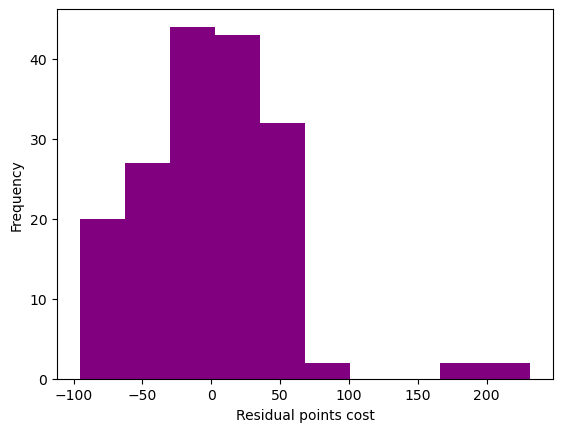

In [8]:
plt.hist(model.resid, color="purple");
plt.xlabel("Residual points cost");
plt.ylabel("Frequency");

In [9]:
# negative fitted value??

# df["fittedvalues"] = model.fittedvalues
# df["resid"] = model.resid
# df["dv"] = dv

# found this neg value for Razorgors, not sure why it predicted -.4 pts?

#model.fittedvalues.sort_values(ascending = True)

#df.iloc[np.where(df["fittedvalues"] < 100)][["unit_name", "Points_per_warscroll", "fittedvalues"]]

#print(model.summary())

#df.iloc[149:155]

#df.iloc[150]

#df.iloc[np.where(df["fittedvalues"] < 60)][["unit_name", "Points_per_warscroll", "fittedvalues"]]

# Solved: inspecting the regression coefs I believe it is predicting low (neg) because of the 
# low wounds X model value and the high (bad) save value, so it's got low values of the
# most important coefs. Decided to leave it in the analysis but set it to 1 point.


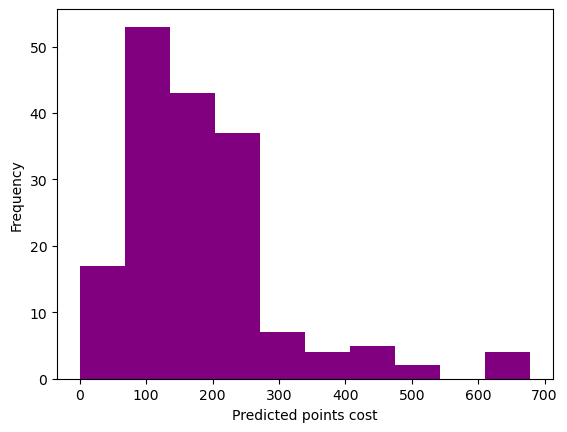

In [10]:
plt.hist(model.fittedvalues, color="purple");
plt.xlabel("Predicted points cost");
plt.ylabel("Frequency");

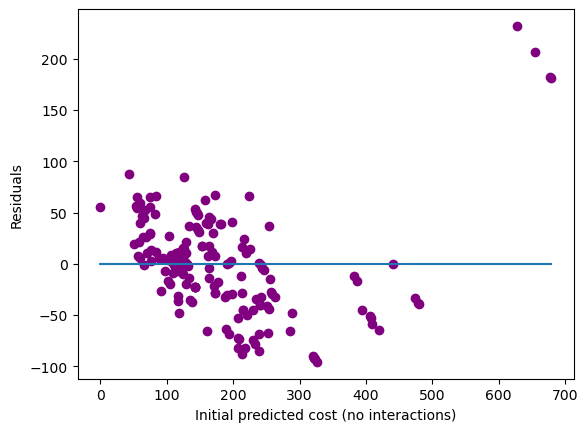

In [11]:
#Resid Scatter Plot (resid vs pred).

b1, b0 = np.polyfit(model.fittedvalues, model.resid, 1)
plt.plot(model.fittedvalues, b1*model.fittedvalues+b0)

plt.scatter(model.fittedvalues, model.resid, color="purple")
plt.xlabel("Initial predicted cost (no interactions)")
plt.ylabel("Residuals")

plt.show()


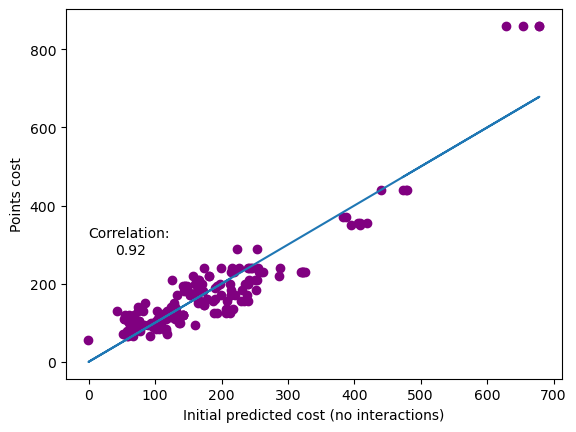

In [12]:
#Resid Scatter Plot (resid vs pred).

b1, b0 = np.polyfit(model.fittedvalues, df["Points_per_warscroll"], 1)
plt.plot(model.fittedvalues, b1*model.fittedvalues+b0)

plt.scatter(model.fittedvalues, df["Points_per_warscroll"], color="purple")
plt.xlabel("Initial predicted cost (no interactions)")
plt.text(0, 320, "Correlation:")
plt.text(40, 275, round(np.corrcoef(model.fittedvalues, df["Points_per_warscroll"])[1][0],2))
plt.ylabel("Points cost")

plt.show()


In [13]:
# Mahalanobis distance.
#https://stackoverflow.com/questions/29817090/is-there-a-python-equivalent-to-the-mahalanobis-function-in-r-if-not-how-can

from scipy.spatial.distance import mahalanobis
import scipy as sp

# returned non-invertable error, adding noise.
x_noise = x+0.00001*np.random.rand(x.shape[0], x.shape[1])

Sx = x_noise.cov().values
Sx = sp.linalg.inv(Sx)

mean = x.mean().values

def mahalanobisR(X,meanCol,IC):
    m = []
    for i in range(X.shape[0]):
        m.append(mahalanobis(X.iloc[i,:],meanCol,IC) ** 2)
    return(m)

mR = mahalanobisR(x,mean,Sx)

mR = pd.DataFrame(mR)
#chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://users.sussex.ac.uk/~grahamh/RM1web/ChiSquareTable2005.pdf
# df 37 @ p <.001 == 69.35
#df[mR[np.where(mR[0] > 69.35)]]

# studentized score.
#np.std(df["Points_per_warscroll"])
# np.mean(df["Points_per_warscroll"])
# #influence.resid_studentized

In [14]:
# Check for outliers.
np.set_printoptions(suppress=True)
influence = model.get_influence()

cooksd = influence.cooks_distance

#df = df[df["Points_per_warscroll"] < 500]

In [15]:
# Checking outliers by cooks d. 

df.unit_name[cooksd[1] < .05]

Series([], Name: unit_name, dtype: object)

In [16]:
# Potential interaction effects to test.

# 2-way interactions.
df["A_X_H"] = preprocessing.scale(df["A"]) * preprocessing.scale(df["H"])
df["A_X_W"] = preprocessing.scale(df["A"]) * preprocessing.scale(df["W"])
df["A_X_D"] = preprocessing.scale(df["A"]) * preprocessing.scale(df["D"])

df["H_X_W"] = preprocessing.scale(df["H"]) * preprocessing.scale(df["W"])
df["H_X_D"] = preprocessing.scale(df["H"]) * preprocessing.scale(df["D"])

df["W_X_D"] = preprocessing.scale(df["W"]) * preprocessing.scale(df["D"])

# Join offensive interactions. 
x = x.join([df["A_X_H"], df["A_X_W"], df["A_X_D"], df["H_X_W"], df["H_X_D"], df["W_X_D"]])

model = sm.OLS(dv, x).fit()
print(model.rsquared)


0.8657788154457646


In [17]:
# More Interactions.
# Potential interaction effects to test.

# 2-way interactions.
df["Wounds_X_Save"] = preprocessing.scale(df["Wounds_X_model"]) * preprocessing.scale(df["Save"])
df["Wounds_X_Ward"] = preprocessing.scale(df["Wounds_X_model"]) * preprocessing.scale(df["Ward"])
df["Wounds_X_Bravery"] = preprocessing.scale(df["Wounds_X_model"]) * preprocessing.scale(df["Bravery"])

df["Save_X_Bravery"] = preprocessing.scale(df["Save"]) * preprocessing.scale(df["Bravery"])
df["Save_X_Ward"] = preprocessing.scale(df["Save"]) * preprocessing.scale(df["Ward"])

df["Ward_X_Bravery"] = preprocessing.scale(df["Ward"]) * preprocessing.scale(df["Bravery"])

# Join offensive interactions. 
x = x.join([df["Wounds_X_Save"], df["Wounds_X_Ward"], df["Wounds_X_Bravery"], df["Save_X_Bravery"], 
            df["Save_X_Ward"], df["Ward_X_Bravery"]])

model = sm.OLS(dv, x).fit()
print(model.rsquared)

0.931646877455359


In [18]:
# 3-way interactions.

df["A_X_H_X_W"] = preprocessing.scale(df["A"]) * preprocessing.scale(df["H"]) * preprocessing.scale(df["W"])
df["H_X_W_X_D"] = preprocessing.scale(df["H"]) * preprocessing.scale(df["W"]) * preprocessing.scale(df["D"])
df["H_X_A_X_D"] = preprocessing.scale(df["H"]) * preprocessing.scale(df["A"]) * preprocessing.scale(df["D"])


df["Wounds_X_Save_X_Ward"] = preprocessing.scale(df["Wounds_X_model"]) * preprocessing.scale(df["Save"]) * preprocessing.scale(df["Ward"])
df["Save_X_Ward_X_Bravery"] = preprocessing.scale(df["Save"]) * preprocessing.scale(df["Ward"]) * preprocessing.scale(df["Bravery"])
df["Save_X_Wounds_X_Bravery"] = preprocessing.scale(df["Save"]) * preprocessing.scale(df["Wounds_X_model"]) * preprocessing.scale(df["Bravery"])

 
x = x.join([df["A_X_H_X_W"], df["H_X_W_X_D"], df["H_X_A_X_D"], df["Wounds_X_Save_X_Ward"],
            df["Save_X_Ward_X_Bravery"], df["Save_X_Wounds_X_Bravery"]]) 

model = sm.OLS(dv, x).fit()
print(model.rsquared)


0.9603378139288608


In [19]:
# Four-way effect.
df["all_damage"] = preprocessing.scale(df["A"]) * preprocessing.scale(df["H"]) * preprocessing.scale(df["W"]) * preprocessing.scale(df["D"])

# Four-way effect.
df["all_defence"] = preprocessing.scale(df["Wounds_X_model"]) * preprocessing.scale(df["Save"]) * preprocessing.scale(df["Ward"]) * preprocessing.scale(df["Bravery"])

df["damage_X_defence"] = df["all_defence"] * df["all_damage"]

x = x.join([df["all_damage"], df["all_defence"], df["damage_X_defence"]]) 

model = sm.OLS(dv, x).fit()
print(model.rsquared)



0.9605894052728734


In [20]:
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Points_per_warscroll   R-squared:                       0.961
Model:                              OLS   Adj. R-squared:                  0.950
Method:                   Least Squares   F-statistic:                     91.40
Date:                  Thu, 16 Nov 2023   Prob (F-statistic):           2.33e-78
Time:                          18:07:02   Log-Likelihood:                -802.52
No. Observations:                   172   AIC:                             1679.
Df Residuals:                       135   BIC:                             1795.
Df Model:                            36                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

In [21]:
# Assign findings to df. 
df["residuals"] = round(model.resid, 2)
df["fittedvalues"] = round(model.fittedvalues, 2)

r2_ols = model.rsquared

#plt.scatter(df["fittedvalues"], df["residuals"])
#plt.show()

#df.sort_values(by = "fittedvalues", ascending = True)

# NOTE: the neg predicted values are corrected here.


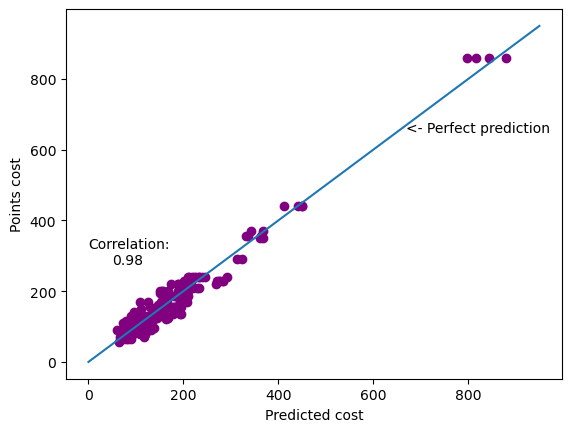

In [22]:
# Final scatterplot.

plt.scatter(model.fittedvalues, dv, color="purple")
plt.xlabel("Predicted cost")
plt.text(0, 320.5, "Correlation:")
plt.text(50, 275.5, round(np.corrcoef(model.fittedvalues, dv)[1][0],2))
plt.ylabel("Points cost")

plt.plot([0,950], [0,950]) # add straight diag line.
plt.text(670, 650, "<- Perfect prediction")


plt.show()

In [23]:
# Print under costed units.

df["resid_%"] = round(df["residuals"]/(df["Points_per_warscroll"]/100),2)

#df = df.sort_values(by = "residuals", ascending = True)
df = df.sort_values(by = "resid_%", ascending = True)

under_costed = df[["unit_name", "fittedvalues", "Points_per_warscroll", "residuals", "resid_%"]]

under_costed.drop_duplicates(subset = ["unit_name"], keep = "first")[0:20]


,unit_name,fittedvalues,Points_per_warscroll,residuals,resid_%
107,Chaos Spawn,117.82,70,-47.82,-68.31
106,Raptoryx,118.38,80,-38.38,-47.98
144,Chaos Warhounds,118.23,80,-38.23,-47.79
100,Furies,130.88,90,-40.88,-45.42
104,Mindstealer Sphiranx,137.24,95,-42.24,-44.46
117,Beasts of Chaos Tzaangor Shaman,194.91,135,-59.91,-44.38
151,Tuskgor Chariots,89.23,65,-24.23,-37.28
155,Ungor Raiders,108.95,80,-28.95,-36.19
24,Infernal Enrapturess,163.37,120,-43.37,-36.14
148,Dragon Ogors,167.17,125,-42.17,-33.74


In [24]:
# Print over costed units.

#df = df.sort_values(by = "residuals", ascending = False)
df = df.sort_values(by = "resid_%", ascending = False)

over_costed = df[["unit_name", "fittedvalues", "Points_per_warscroll", "residuals", "resid_%"]]

over_costed.drop_duplicates(subset = ["unit_name"], keep = "first")[0:20]

,unit_name,fittedvalues,Points_per_warscroll,residuals,resid_%
48,Fiends,107.64,170,62.36,36.68
39,Daemonettes,72.20,110,37.80,34.36
96,Untamed Beasts,60.27,90,29.73,33.03
141,Bullgors,88.68,130,41.32,31.78
70,Chaos Lord,79.10,115,35.90,31.22
38,Blissbarb Archers,96.35,140,43.65,31.18
139,Bestigors,91.27,125,33.73,26.98
127,Grashrak Fellhoof,110.71,150,39.29,26.19
163,Chimera,151.42,200,48.58,24.29
136,Beasts of Chaos Tzaangor Skyfires,151.75,195,43.25,22.18


In [25]:
#SVM reg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
 
# create an SVR model with a linear kernel 
svr = SVR(C = 1.0, epsilon = 0.1, kernel='rbf') 
 
# train the model on the data 
svr.fit(x, dv) 
 
# make predictions on the data 
y_pred = svr.predict(x) 

# R2 for SVM.
r2_svm = np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0]
print(np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0])


0.5142637517306122


In [26]:
# RF
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True)
rfreg.fit(x, dv)

# Compute the out-of-bag R-squared score.
r2_rf = rfreg.oob_score_
print((rfreg.oob_score_))


0.9472034119923357


In [27]:
# Neural Network.
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000).fit(x, dv)
regr.predict(x[:2])

# R2 from nn.
r2_nn = regr.score(x, dv)
print( regr.score(x, dv))


0.9512741259330774


C:\Users\SPEDJ1\AppData\Local\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
# Regression
print(r2_ols)

0.9605894052728734


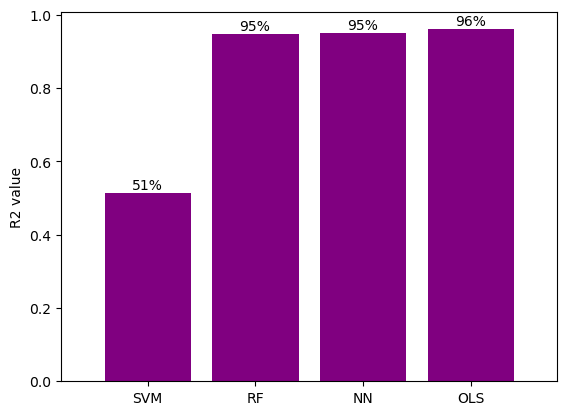

In [29]:
# Graphing the final R2 values.

# metrics = pd.DataFrame([np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0],
#            rfreg.oob_score_,
#            regr.score(x, dv),
#            model.rsquared])

# metrics = metrics.T

# metrics.columns = ["SVM", "RF", "NN", "OLS"]

# started making a df then found below:
# https://stackoverflow.com/questions/34302380/how-to-plot-a-bar-plot-with-matplotlib-using-two-single-values

# the data you want to plot
categories = ["SVM", "RF", "NN", "OLS"]
values     = [np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0],
              rfreg.oob_score_,
              regr.score(x, dv),
              model.rsquared]
# x-values for the center of each bar
xs = np.arange(1, len(categories) + 1)
# plot each bar centered
plt.bar(xs - .8/4, values, width=.8, color="purple")
# add bar labels
plt.xticks(xs-.2, categories)
plt.ylabel("R2 value")
# make sure the chart is centered
plt.xlim(0, len(categories) + .6)

plt.text(.65, (np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0]) + .01,
         str(round(np.corrcoef(dv, y_pred)[1][0] * np.corrcoef(dv, y_pred)[1][0]*100))+"%")
plt.text(1.65, (rfreg.oob_score_+.01), str(round(rfreg.oob_score_*100))+"%")
plt.text(2.65, (regr.score(x, dv) +.01), str(round(regr.score(x, dv)*100))+"%")
plt.text(3.65, (model.rsquared+.01), str(round(model.rsquared*100))+"%")

# show the results
plt.show()

In [30]:
# https://www.datacamp.com/tutorial/xgboost-in-python
# found guide for xgb but forget i needed an internal test set for the internal cv tuning function. So
# might come back later but I dont think I have sufficient n.

In [31]:
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error

# preds = model.predict(dtest_reg)

In [32]:
# mse = np.mean((actual - predicted) ** 2)
# rmse = np.sqrt(mse)

In [33]:
# params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

In [34]:
# params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

# n = 100
# model = xgb.train(
#    params=params,
#    dtrain=dtrain_reg,
#    num_boost_round=n,
# )